In [2]:
from quspin.basis import spin_basis_general  # Hilbert space spin basis
import numpy as np  # generic math functions
from quspin.operators import quantum_operator, hamiltonian
from quspin.tools import lanczos

In [3]:
import pyrochlore
import visual
import lattice
import matplotlib.pyplot as plt
from sympy import Matrix
import itertools 
from tqdm import tqdm

In [4]:
def is_identity(p:list):
    return all(x == j for (j,x) in enumerate(p))

def perm_order(p:list):
    order=1
    tmp = [x for x in p]
    while not is_identity(tmp):
        tmp = [p[x] for x in tmp]
        order += 1
        if order > len(p):
            raise Exception("perm is broken")
    return order

In [5]:
def construct_hamiltonian_spec(lat: lattice.Lattice, Jzz, Jpm, B):
    Ising_opspec = []
    xc_opspec = []
    
    for bond in lat.bonds:
        Ising_opspec.append([Jzz, bond['from_idx'], bond['to_idx']])
        xc_opspec.append([Jpm, bond['from_idx'], bond['to_idx']])
    # gx_opspec = [[g, i] for i in range(L)]

    return dict(
        static =  [["zz", Ising_opspec], ["+-", xc_opspec], ["-+", xc_opspec]],
        lat = lat
    )

def get_symmetries(lat):
    T1, T2, T3 = lat.get_transl_generators()
    I = lat.get_inversion_perm([0,0,0])

    syms = {
        "T1": T1,
        "T2": T2,
        "T3": T3,
        "I": I,
        'P01': full_lat.get_refl_perm(origin=Matrix([0,1,1]), direction=Matrix([0,1,1]) ),
        'P02': full_lat.get_refl_perm(origin=Matrix([1,0,1]), direction=Matrix([1,0,1]) ),
        'P03': full_lat.get_refl_perm(origin=Matrix([1,1,0]), direction=Matrix([1,1,0]) )
    }

    nontriv_syms = {}
    for s in syms:
        if not is_identity(syms[s]):
            nontriv_syms[s] = syms[s]
    return nontriv_syms
    
def calc_hamiltonian(hamspec, silent=False, **kwargs ):
    """
    Calculates the actual sparse hamiltonian
    @param hamspec -> output of construct_hamiltonian_spec
    kwargs: pass in the form n_T_1 = n
    """
    syms = get_symmetries(hamspec["lat"])


    args_to_spin_basis = {}
    for k in kwargs:
        if type(kwargs[k]) is not int:
            raise "kwargs specify rep, must start with 'k_' and be integer"
        if k in syms:
            args_to_spin_basis[k+"_block"] = (syms[k],kwargs[k])
            
    
    
    basis = spin_basis_general(
        hamspec["lat"].num_atoms,
         **args_to_spin_basis
    )
    if not silent:
        print("basis dim: ", basis.Ns)
    
    ham_kwargs = {}
    if silent:
        ham_kwargs = dict(check_herm=False,check_symm=False)
        
    H = hamiltonian(hamspec["static"], [], basis=basis, 
                    dtype=np.complex128,
                    **ham_kwargs)
                   
    return basis, H




In [6]:
def diagonalise(basis, H, lat, krylov_dim=50):
    v0 = np.random.normal(0, 1, size=basis.Ns)
    
    # m_GS = 150  # Krylov subspace dimension
    #
    # Lanczos finds the largest-magnitude eigenvalues:
    E, V, Q_T = lanczos.lanczos_full(H, v0, krylov_dim, full_ortho=False)
    # compute ground state vector
    psi_GS_lanczos = lanczos.lin_comb_Q_T(V[:, 0], Q_T)
    return E[0], psi_GS_lanczos

def calc_ringflip(psi_GS_lanczos, lat):
    ringflip_idx = pyrochlore.get_ringflips(lat)
    
    # ringflip_spec = hamiltonian([["+-+-+-", [1.] +  ringflip_idx[0] ]],[])
    static_rf = [["+-+-+-", [[1/len(ringflip_idx)]+rf for rf in ringflip_idx ]]]
    
    sum_ringflip_op = hamiltonian(static_rf,[],basis=basis,check_herm=False,check_symm=False)
    
    return psi_GS_lanczos.dot(sum_ringflip_op.dot(psi_GS_lanczos))


In [7]:
######################################
###### CONSTANTS AND SETUP  ##########
######################################


Jpm_sweep = np.linspace(-0.1,0.2,20)

cell =[[2,0,0],[0,2,0],[0,0,2]]

full_lat = lattice.Lattice(pyrochlore.primitive, cell)

coupling_consts = dict(
        Jzz=1.0,
        Jpm=None,
        B=[0,0,0]
    )                

In [8]:
### NAIVE DIAG
if full_lat.num_atoms > 16:
    raise Exception("Too big mate")

naive_ringflip_vals = []
naive_energy = []

for jpm in tqdm(Jpm_sweep):
    coupling_consts["Jpm"] = jpm
    
    hamspec = construct_hamiltonian_spec(full_lat, **coupling_consts)
    basis, H = calc_hamiltonian(hamspec, silent=True)
    E, psi_GS = diagonalise(basis, H, full_lat, krylov_dim=150)

    naive_energy.append(E)
    naive_ringflip_vals.append(calc_ringflip(psi_GS, full_lat))



Exception: Too big mate

In [9]:

lattice_symmetries = get_symmetries(full_lat)
print(lattice_symmetries)
chosen_symmetries = {k: lattice_symmetries[k] for k in ['T1', 'T2', 'T3', 'I','P01']}

{'T1': [1, 0, 3, 2, 5, 4, 7, 6, 9, 8, 11, 10, 13, 12, 15, 14, 17, 16, 19, 18, 21, 20, 23, 22, 25, 24, 27, 26, 29, 28, 31, 30], 'T2': [2, 3, 0, 1, 6, 7, 4, 5, 10, 11, 8, 9, 14, 15, 12, 13, 18, 19, 16, 17, 22, 23, 20, 21, 26, 27, 24, 25, 30, 31, 28, 29], 'T3': [4, 5, 6, 7, 0, 1, 2, 3, 12, 13, 14, 15, 8, 9, 10, 11, 20, 21, 22, 23, 16, 17, 18, 19, 28, 29, 30, 31, 24, 25, 26, 27], 'I': [0, 1, 2, 3, 4, 5, 6, 7, 9, 8, 11, 10, 13, 12, 15, 14, 18, 19, 16, 17, 22, 23, 20, 21, 28, 29, 30, 31, 24, 25, 26, 27], 'P01': [8, 9, 11, 10, 13, 12, 14, 15, 0, 1, 3, 2, 5, 4, 6, 7, 16, 17, 19, 18, 21, 20, 22, 23, 24, 25, 27, 26, 29, 28, 30, 31], 'P02': [16, 19, 18, 17, 22, 21, 20, 23, 8, 11, 10, 9, 14, 13, 12, 15, 0, 3, 2, 1, 6, 5, 4, 7, 24, 27, 26, 25, 30, 29, 28, 31], 'P03': [24, 29, 30, 27, 28, 25, 26, 31, 8, 13, 14, 11, 12, 9, 10, 15, 16, 21, 22, 19, 20, 17, 18, 23, 0, 5, 6, 3, 4, 1, 2, 7]}


In [10]:
### SYMMETRY AWARE DIAGONALISATION

# Diagonalise in each sector
sectors = {}



for symlabel in chosen_symmetries:
    N = perm_order(lattice_symmetries[symlabel])
    sectors[symlabel] = range(N)

ringflip_vals = {}

sector_list = [x for x in itertools.product(*sectors.values())]

print(sector_list)

chosen_sector_list = sector_list[0:6]
chosen_sector_list

[(0, 0, 0, 0, 0), (0, 0, 0, 0, 1), (0, 0, 0, 1, 0), (0, 0, 0, 1, 1), (0, 0, 1, 0, 0), (0, 0, 1, 0, 1), (0, 0, 1, 1, 0), (0, 0, 1, 1, 1), (0, 1, 0, 0, 0), (0, 1, 0, 0, 1), (0, 1, 0, 1, 0), (0, 1, 0, 1, 1), (0, 1, 1, 0, 0), (0, 1, 1, 0, 1), (0, 1, 1, 1, 0), (0, 1, 1, 1, 1), (1, 0, 0, 0, 0), (1, 0, 0, 0, 1), (1, 0, 0, 1, 0), (1, 0, 0, 1, 1), (1, 0, 1, 0, 0), (1, 0, 1, 0, 1), (1, 0, 1, 1, 0), (1, 0, 1, 1, 1), (1, 1, 0, 0, 0), (1, 1, 0, 0, 1), (1, 1, 0, 1, 0), (1, 1, 0, 1, 1), (1, 1, 1, 0, 0), (1, 1, 1, 0, 1), (1, 1, 1, 1, 0), (1, 1, 1, 1, 1)]


[(0, 0, 0, 0, 0),
 (0, 0, 0, 0, 1),
 (0, 0, 0, 1, 0),
 (0, 0, 0, 1, 1),
 (0, 0, 1, 0, 0),
 (0, 0, 1, 0, 1)]

In [ ]:
for sector in chosen_sector_list:
    print(list(sectors.keys()),":", sector)
    ringflip_vals[sector] = []
    for jpm in tqdm(Jpm_sweep):
        coupling_consts["Jpm"] = jpm
        
        hamspec = construct_hamiltonian_spec(full_lat, **coupling_consts)
        
        symmetry_evals = {k:v for k, v in zip(sectors.keys(), sector) }
        basis, H = calc_hamiltonian(hamspec, silent=False, **symmetry_evals, Nup=16)
        
        E, psi_GS = diagonalise(basis, H, full_lat, krylov_dim = 150)

        rf = calc_ringflip(psi_GS, full_lat)
        
        ringflip_vals[sector].append(dict(
            energy=E,
            ringflip=rf
            ))

['T1', 'T2', 'T3', 'I', 'P01'] : (0, 0, 0, 0, 0)


  0%|                                                                                                                                                                                | 0/20 [00:00<?, ?it/s]/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_80841/273398490.py:53: GeneralBasisWarning: using non-commuting symmetries can lead to unwanted behaviour of general basis, make sure that quantum numbers are invariant under non-commuting symmetries!
  basis = spin_basis_general(


basis dim:  134473792
Hermiticity check passed!
Symmetry checks passed!


(-25.0, -15.0)

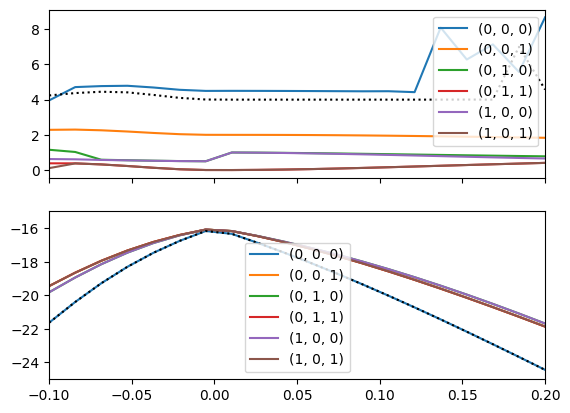

In [44]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex=True)

for sector in ringflip_vals:
    E = [x['energy'] for x in ringflip_vals[sector]]
    rf = [x['ringflip'] for x in ringflip_vals[sector]]

    ax1.plot(Jpm_sweep, np.real(rf), label=str(sector))
    ax2.plot(Jpm_sweep, E, label=str(sector))

ax1.plot(Jpm_sweep, np.real(naive_ringflip_vals), 'k:')
ax2.plot(Jpm_sweep, naive_energy, 'k:')

ax1.legend()
ax2.legend()
ax1.set_xlim([-0.1,0.2])
ax2.set_ylim([-25,-15])
